In [452]:
# Imports
from ypstruct import structure
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.spatial.distance import pdist, squareform
import re
import seaborn as sns
from scipy.sparse import lil_matrix

In [453]:
def read_TTP_instance_data(file_path):
    nb_items = int(file_path.split("-")[1].strip("n").split(".txt")[0])
    nb_cities = int(re.sub("\D", "", file_path.split("-")[0].split("/")[2]))
    # Read node coordinates from the file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Initialize variables
    node_coordinates = []
    item_values = []
    item_weights= []
    in_node_section = False
    in_item_section = False
    item_to_city_mapping_dict = {}
    v_min = None
    v_max = None
    max_capacity = None
    renting_ratio = None
    item_to_city_mapping_matrix = lil_matrix((nb_items, nb_cities), dtype = int)

    for i in range(nb_cities):
        item_to_city_mapping_dict[i] = []

    # Extract node coordinates and item data
    for line in lines:
        if line.startswith("CAPACITY OF KNAPSACK"):
            max_capacity = int(line.strip().split()[3])
            continue
        elif line.startswith("MIN SPEED"):
            v_min = float(line.strip().split()[2])
        elif line.startswith("MAX SPEED"):
            v_max = float(line.strip().split()[2])
        elif line.startswith("RENTING RATIO"):
            renting_ratio = float(line.strip().split()[2])
        elif line.startswith('NODE_COORD_SECTION'):
            in_node_section = True
            in_item_section = False
            continue
        elif line.startswith('ITEMS SECTION'):
            in_node_section = False
            in_item_section = True
            continue
        elif line.startswith('EOF'):
            break
        
        if in_node_section:
            _, x, y = map(int, line.strip().split())
            node_coordinates.append((x, y))
        elif in_item_section:
            item_id, profit, weight, node_number = map(int, line.strip().split())
            item_to_city_mapping_dict[node_number - 1].append(item_id-1) # re-index to 0
            item_to_city_mapping_matrix[item_id - 1, node_number - 1] = 1
            item_values.append(profit)
            item_weights.append(weight)
    
    value_to_weight_ratio = np.array(item_values) / np.array(item_weights)
    value_to_weight_ratio_dict = {}
    for i in range(len(value_to_weight_ratio)):
        value_to_weight_ratio_dict[i] = value_to_weight_ratio[i]
    
    return {"nb_cities": nb_cities,
            "nb_items": nb_items,
            "Q": max_capacity, 
            "v_min": v_min, 
            "v_max": v_max, 
            "R": renting_ratio, 
            "pairwise_distances": pdist(node_coordinates), 
            "item_to_city_mapping_dict":item_to_city_mapping_dict,
            "item_to_city_mapping_matrix": item_to_city_mapping_matrix,
            "item_weights": np.array(item_weights),
            "item_values": np.array(item_values),
            "value_to_weight_ratio_dict": value_to_weight_ratio_dict
            }

In [454]:
test = read_TTP_instance_data("../data/fnl4461-n44600.txt")

In [455]:
test["item_to_city_mapping_matrix"].getcol(1).toarray().flatten()[test["item_to_city_mapping_matrix"].getcol(1).toarray().flatten() == 1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [456]:
test["item_to_city_mapping_dict"]

{0: [],
 1: [0, 4460, 8920, 13380, 17840, 22300, 26760, 31220, 35680, 40140],
 2: [1, 4461, 8921, 13381, 17841, 22301, 26761, 31221, 35681, 40141],
 3: [2, 4462, 8922, 13382, 17842, 22302, 26762, 31222, 35682, 40142],
 4: [3, 4463, 8923, 13383, 17843, 22303, 26763, 31223, 35683, 40143],
 5: [4, 4464, 8924, 13384, 17844, 22304, 26764, 31224, 35684, 40144],
 6: [5, 4465, 8925, 13385, 17845, 22305, 26765, 31225, 35685, 40145],
 7: [6, 4466, 8926, 13386, 17846, 22306, 26766, 31226, 35686, 40146],
 8: [7, 4467, 8927, 13387, 17847, 22307, 26767, 31227, 35687, 40147],
 9: [8, 4468, 8928, 13388, 17848, 22308, 26768, 31228, 35688, 40148],
 10: [9, 4469, 8929, 13389, 17849, 22309, 26769, 31229, 35689, 40149],
 11: [10, 4470, 8930, 13390, 17850, 22310, 26770, 31230, 35690, 40150],
 12: [11, 4471, 8931, 13391, 17851, 22311, 26771, 31231, 35691, 40151],
 13: [12, 4472, 8932, 13392, 17852, 22312, 26772, 31232, 35692, 40152],
 14: [13, 4473, 8933, 13393, 17853, 22313, 26773, 31233, 35693, 40153],
 15

In [459]:
test["item_to_city_mapping_matrix"].getnnz

<bound method lil_matrix.getnnz of <44600x4461 sparse matrix of type '<class 'numpy.int32'>'
	with 44600 stored elements in List of Lists format>>

#### Replicating the example evaluation of a candidate solution found in as found https://link.springer.com/chapter/10.1007/978-3-319-54157-0_4

Setting up the problem example

In [460]:
item_values = np.array([30, 34, 40, 25])
item_weights = np.array([25, 30, 40, 21])

item_to_city_mapping_dict = {0:[0], 1:[1], 2:[2], 3:[3]}
item_to_city_mapping_matrix = lil_matrix((4, 4), dtype=int)
item_to_city_mapping_matrix[0, 0] = 1
item_to_city_mapping_matrix[1, 1] = 1
item_to_city_mapping_matrix[2, 2] = 1
item_to_city_mapping_matrix[3, 3] = 1
distance_matrix = np.array(
    [
    [0, 4, 9, 3],
    [4, 0, 5, 5],
    [9, 5, 0, 8],
    [3, 5, 8, 0]
    ]
).astype(float)

vmax = 1.0
vmin = 0.1
Q = 80

In [461]:
item_to_city_mapping_matrix.getcol(0).toarray().flatten()

array([1, 0, 0, 0], dtype=int32)

In [462]:
ex_node_coords = [(5, 5), (9, 5), (13, 2), (5, 2)]

In [463]:
dist_mat = squareform(pdist(ex_node_coords))
dist_mat

array([[0.        , 4.        , 8.54400375, 3.        ],
       [4.        , 0.        , 5.        , 5.        ],
       [8.54400375, 5.        , 0.        , 8.        ],
       [3.        , 5.        , 8.        , 0.        ]])

Cost function for the knapsack, as given by:
$$
  \sum^m_{j = 1} z_j * b_j
$$
where $z_j$ is the a binary vector where each index corresponds to an item and is 0 if the item is not picked and 1 if it is and $b_j$ is the values vector.

In [464]:
def knapsack_cost(candidate_solution, item_values):
    return np.sum(np.array(candidate_solution.packing_plan) * item_values)

Cost function for the tour, taking into account velocity, as given by:
$$
    f(\pi, z) = \frac{d_{\pi_1, \pi_{n}} * R}{v(w(\pi_{n}))} + \sum^{n-1}_{i = 1} \frac{d_{\pi_i, \pi_{i+1}} * R}{v(w(\pi_{i}))}
$$ 
where 
$$
    w(\pi_i) = \sum^{i}_{k=1}\sum^{m}_{j=1} z_j * b_j * a_{j, \pi_i}
$$ 

and 
$$
    v(q) = v_{max} - \frac{q}{Q} * (v_{max} - v_{min})
$$ 

where $d_{\pi_i, \pi_{i+1}}$ is the distance between city $i$ and $i+1$, obtained from the distance matrix $d$ and $a$ is the item mapping matrix and R is the renting ratio

In [465]:
def tour_cost(candidate_solution, distance_matrix, item_to_city_mapping_dict, item_weights, vmax, vmin, Q, renting_ratio):
    tour = candidate_solution.tour
    
    # calculate the weight picked up at each city
    weight_at_city_i = []
    for city in tour:
        # Create a row filled with zeros for the selected item
        item_city_row = np.zeros(len(item_weights), dtype=int)
        items_in_city = item_to_city_mapping_dict[city]
        # Fill in the row based on the item to city mapping for the selected item
        item_city_row[items_in_city] = 1

        weight_at_city_i.append(sum(item_city_row * np.array(candidate_solution.packing_plan) * item_weights))
    # calculate the total weight that the thief has when leaving each city using the cumulative sum 
    weight_at_city_i = np.array(np.cumsum(weight_at_city_i))
    # calculate the velocity of the thief when leaving each city
    velocity_at_city_i = vmax - weight_at_city_i / Q * (vmax - vmin)
    # retrieve the distance between the cities 
    distance_between_cities = []


    for i in range(0, len(tour)-1):

        distance_between_cities.append(distance_matrix[tour[i]][tour[i+1]])
    distance_between_cities.append(distance_matrix[tour[0]][tour[-1]])
    distance_between_cities = np.array(distance_between_cities)
    
    # return the total completion time
    return np.sum(distance_between_cities / velocity_at_city_i) * renting_ratio

In [466]:
def get_pdist_distance(pairwise_distances, i, j, nb_cities):
     if i < j:
        return pairwise_distances[nb_cities * i + j - ((i + 2) * (i + 1)) // 2]
     elif i > j:
        return pairwise_distances[nb_cities * j + i - ((j + 2) * (j + 1)) // 2]


In [506]:
def tour_cost_pdist(candidate_solution, pairwise_distances, item_to_city_mapping_matrix, item_weights, vmax, vmin, Q, renting_ratio):
    tour = candidate_solution.tour
    nb_cities = len(tour)
    # calculate the weight picked up at each city
    weight_at_city_i = [
        sum(item_to_city_mapping_matrix.getcol(city).toarray().flatten() * np.array(candidate_solution.packing_plan) * item_weights) for city in tour
        ]
    # for city in tour:
    #     # Create a row filled with zeros for the selected item
    #     item_city_row = item_to_city_mapping_matrix.getcol(city).toarray().flatten()
    #     weight_at_city_i.append(sum(item_city_row * np.array(candidate_solution.packing_plan) * item_weights))
        
    # calculate the total weight that the thief has when leaving each city using the cumulative sum 
    weight_at_city_i = np.cumsum(weight_at_city_i)
    # calculate the velocity of the thief when leaving each city
    velocity_at_city_i = vmax - weight_at_city_i / Q * (vmax - vmin)
    # retrieve the distance between the cities 
    distance_between_cities = []


    distance_between_cities = [get_pdist_distance(pairwise_distances, tour[i], tour[i+1], nb_cities) for i in range(0, len(tour) - 1)]
    distance_between_cities.append(get_pdist_distance(pairwise_distances, tour[0], tour[-1], nb_cities))
    distance_between_cities = np.array(distance_between_cities)
    
    # return the total completion time
    return np.sum(distance_between_cities / velocity_at_city_i) * renting_ratio

In [505]:
type(np.cumsum([1, 2, 3, 4]))

numpy.ndarray

In [484]:
def evaluate_candidate_solution_cost(candidate_solution, distance_matrix, item_to_city_mapping_matrix, item_weights, item_values, vmax, vmin, Q, renting_ratio):
    candidate_solution.tour_cost = tour_cost(candidate_solution, distance_matrix, item_to_city_mapping_matrix, item_weights, vmax, vmin, Q, renting_ratio)
    candidate_solution.packing_plan_cost = knapsack_cost(candidate_solution, item_values)
    return candidate_solution

In [485]:
def evaluate_candidate_solution_cost_pdist(candidate_solution, pairwise_distances, item_to_city_mapping_matrix, item_weights, item_values, vmax, vmin, Q, renting_ratio):
    candidate_solution.tour_cost = tour_cost_pdist(candidate_solution, pairwise_distances, item_to_city_mapping_matrix, item_weights, vmax, vmin, Q, renting_ratio)
    candidate_solution.packing_plan_cost = knapsack_cost(candidate_solution, item_values)
    return candidate_solution

Setting up the example candidate solutions and evaluating them using the previously defined function

In [486]:
ex_tours = [[1, 2, 3, 4], [1, 4, 3, 2], [1, 2, 3, 4], [1, 4, 3, 2], [1, 4, 3, 2], [1, 3, 2, 4],  [1, 4, 3, 2], [1, 2, 3, 4], [1, 4, 3, 2], [1, 3, 2, 4]]
ex_packing_plans = [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 1], [0, 1, 0, 0], [0, 0, 1, 0], [0, 1, 0, 1], [1, 1, 0, 0], [0, 0, 1, 1], [0, 1, 1, 0], [1, 1, 0, 1]]

In [487]:
ex_init_pop = []
for i in range(len(ex_tours)):
    candidate_solution = structure()
    candidate_solution.tour = list(np.array(ex_tours[i])-1)
    candidate_solution.packing_plan = ex_packing_plans[i]
    evaluate_candidate_solution_cost(candidate_solution, distance_matrix, item_to_city_mapping_dict, item_weights, item_values, vmax, vmin, Q, 1)
    ex_init_pop.append(candidate_solution)
ex_init_pop

[struct({'tour': [0, 1, 2, 3], 'packing_plan': [0, 0, 0, 0], 'tour_cost': 20.0, 'packing_plan_cost': 0}),
 struct({'tour': [0, 3, 2, 1], 'packing_plan': [0, 0, 0, 0], 'tour_cost': 20.0, 'packing_plan_cost': 0}),
 struct({'tour': [0, 1, 2, 3], 'packing_plan': [0, 0, 0, 1], 'tour_cost': 20.927986906710313, 'packing_plan_cost': 25}),
 struct({'tour': [0, 3, 2, 1], 'packing_plan': [0, 1, 0, 0], 'tour_cost': 22.037735849056602, 'packing_plan_cost': 34}),
 struct({'tour': [0, 3, 2, 1], 'packing_plan': [0, 0, 1, 0], 'tour_cost': 27.363636363636363, 'packing_plan_cost': 40}),
 struct({'tour': [0, 2, 1, 3], 'packing_plan': [0, 1, 0, 1], 'tour_cost': 28.585292978476183, 'packing_plan_cost': 59}),
 struct({'tour': [0, 3, 2, 1], 'packing_plan': [1, 1, 0, 0], 'tour_cost': 32.75267284390591, 'packing_plan_cost': 64}),
 struct({'tour': [0, 1, 2, 3], 'packing_plan': [0, 0, 1, 1], 'tour_cost': 33.107207533502354, 'packing_plan_cost': 65}),
 struct({'tour': [0, 3, 2, 1], 'packing_plan': [0, 1, 1, 0], 't

In [488]:
ex_init_pop = []
for i in range(len(ex_tours)):
    candidate_solution = structure()
    candidate_solution.tour = list(np.array(ex_tours[i])-1)
    candidate_solution.packing_plan = ex_packing_plans[i]
    evaluate_candidate_solution_cost_pdist(candidate_solution, pdist(ex_node_coords), item_to_city_mapping_matrix, item_weights, item_values, vmax, vmin, Q, 1)
    ex_init_pop.append(candidate_solution)
ex_init_pop

[struct({'tour': [0, 1, 2, 3], 'packing_plan': [0, 0, 0, 0], 'tour_cost': 20.0, 'packing_plan_cost': 0}),
 struct({'tour': [0, 3, 2, 1], 'packing_plan': [0, 0, 0, 0], 'tour_cost': 20.0, 'packing_plan_cost': 0}),
 struct({'tour': [0, 1, 2, 3], 'packing_plan': [0, 0, 0, 1], 'tour_cost': 20.927986906710313, 'packing_plan_cost': 25}),
 struct({'tour': [0, 3, 2, 1], 'packing_plan': [0, 1, 0, 0], 'tour_cost': 22.037735849056602, 'packing_plan_cost': 34}),
 struct({'tour': [0, 3, 2, 1], 'packing_plan': [0, 0, 1, 0], 'tour_cost': 27.363636363636363, 'packing_plan_cost': 40}),
 struct({'tour': [0, 2, 1, 3], 'packing_plan': [0, 1, 0, 1], 'tour_cost': 28.12929672379371, 'packing_plan_cost': 59}),
 struct({'tour': [0, 3, 2, 1], 'packing_plan': [1, 1, 0, 0], 'tour_cost': 32.75267284390591, 'packing_plan_cost': 64}),
 struct({'tour': [0, 1, 2, 3], 'packing_plan': [0, 0, 1, 1], 'tour_cost': 33.107207533502354, 'packing_plan_cost': 65}),
 struct({'tour': [0, 3, 2, 1], 'packing_plan': [0, 1, 1, 0], 'to

In [489]:
def random_tour(nb_cities):
    return random.sample(list(range(nb_cities)), k = nb_cities)

In [490]:
def pack_one(init_pop, nb_items):
    for candidate_solution in init_pop:
        packing_plan = np.zeros(nb_items)
        chosen_item = random.sample(list(range(nb_items)), k = 1)
        packing_plan[chosen_item] = 1
        candidate_solution.packing_plan = list(packing_plan)
    return init_pop

In [491]:
def pack_random(init_pop, item_to_city_mapping_dict, nb_items):
    for candidate_solution in init_pop:
        packing_plan = [random.choice(list(range(2))) for _ in range(nb_items)]
        candidate_solution.packing_plan = packing_plan
    return init_pop

In [492]:
def pack_optimal(init_pop, item_to_city_mapping_dict, Q, value_to_weight_ratio_dict, item_weights):

    number_of_items = len(item_weights)
    
    sorted_value_to_weight_ratio_dict = dict(sorted(value_to_weight_ratio_dict.items(), key=lambda x:x[1], reverse = True))
    keys_list = list(sorted_value_to_weight_ratio_dict.keys())

    for candidate_solution in init_pop:
        Q_prime = np.random.randint(low = 0, high = Q, size = 1)
        packing_plan = np.zeros(number_of_items)
        weight  = 0
        for i in range(number_of_items):
            if weight + item_weights[keys_list[i]] < Q_prime:

                packing_plan[keys_list[i]] = 1
                weight += item_weights[keys_list[i]]
            else:
                break
        candidate_solution.packing_plan = list(packing_plan)
    return init_pop

In [493]:
def generate_initial_population(pop_size, distance_matrix, item_to_city_mapping_dict, pack_init_method, tour_init_method = "random", Q = None, value_to_weight_ratio_dict = None, item_weights = None): # Jack

    init_pop = []
    nb_cities = len(item_to_city_mapping_dict.keys())
    if tour_init_method == "random":
        for _ in range(pop_size):
            candidate_solution = structure()
            candidate_solution.tour = random_tour(nb_cities)
            init_pop.append(candidate_solution)

    if pack_init_method == "pack_random":
        pack_random(init_pop, item_to_city_mapping_dict, len(item_weights))
    elif pack_init_method == "pack_one":
        pack_one(init_pop, item_to_city_mapping_dict, len(item_weights))
    elif pack_init_method:
        pack_optimal(init_pop, item_to_city_mapping_dict, Q, value_to_weight_ratio_dict, item_weights)

    return init_pop

In [494]:
def packing_plan_crossover(parent1, parent2, crossover_type):

    child1 = parent1.copy()
    child2 = parent2.copy()

    child1_packing_plan = np.array(child1.packing_plan)
    child2_packing_plan = np.array(child2.packing_plan)


    if crossover_type == "single_point":
        crossover_point = random.sample(range(len(parent1.packing_plan)), k = 1)[0]
        child1.packing_plan[0:crossover_point] = child2.packing_plan[0:crossover_point]
        child2.packing_plan[0:crossover_point] = child1.packing_plan[0:crossover_point]

    elif crossover_type == "two_point":
        crossover_points = random.sample(range(len(parent1.packing_plan)), k = 2)
        crossover_points = sorted(crossover_points)
        first_cross_point = crossover_points[0]
        second_cross_point = crossover_points[1]     
        child1.packing_plan[first_cross_point:second_cross_point] = child2_packing_plan[first_cross_point:second_cross_point]
        child2.packing_plan[first_cross_point:second_cross_point] = child1_packing_plan[first_cross_point:second_cross_point]

        return child1, child2

In [495]:
c1 = structure()
c2 = structure()

c1.packing_plan = np.array(random.sample(list(range(10)), k = 10))
c2.packing_plan = np.array(random.sample(list(range(10)), k = 10))

print(c1)
print(c2)
packing_plan_crossover(c1, c2, "two_point")

struct({'packing_plan': array([8, 4, 5, 0, 1, 9, 6, 2, 7, 3])})
struct({'packing_plan': array([3, 4, 8, 0, 6, 2, 5, 1, 7, 9])})


(struct({'packing_plan': array([3, 4, 8, 0, 6, 2, 6, 2, 7, 3])}),
 struct({'packing_plan': array([8, 4, 5, 0, 1, 9, 5, 1, 7, 9])}))

In [496]:
a280_n1395 = read_TTP_instance_data("../data/a280-n2790.txt")

In [497]:
init_pop = generate_initial_population(50, 
                                       None, 
                                       a280_n1395["item_to_city_mapping_dict"], 
                                       "pack_optimal", 
                                       "random", 
                                       a280_n1395["Q"], 
                                       a280_n1395["value_to_weight_ratio_dict"],
                                       a280_n1395["item_weights"])

In [498]:
evaled_pop = []
i = 0
for candidate_solution in init_pop:
    print(i)
    evaluate_candidate_solution_cost_pdist(candidate_solution,
                                     a280_n1395["pairwise_distances"],
                                     a280_n1395["item_to_city_mapping_matrix"],
                                     a280_n1395["item_weights"],
                                     a280_n1395["item_values"],
                                     a280_n1395["v_max"],
                                     a280_n1395["v_min"],
                                     a280_n1395["Q"],
                                     a280_n1395["R"])
    i += 1 
    evaled_pop.append(candidate_solution)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [499]:
def get_ranks(population): # Ursula
    # return (rank, structure()) or candidate solution object as represented above with an additional "rank" attribute
    # doesn't need to return anything if only adding "rank" attribute to candidate solution.
    # Probs easier for later functions if just add crowding_distance attribute to candidate solution
    #Current front set
    f = []
    #Sets for the entire population
    big_s = []
    #dominant individuals for the entire population
    big_np = []
    for p in population:
        #S is the set of individuals that are dominated by p
        s = []
        #np = the number of individuals that dominate p
        np = 0
        for q in population:
            if q.packing_plan_cost < p.packing_plan_cost and q.tour_cost >= p.tour_cost:
                s.append(q)
            elif q.packing_plan_cost <= p.packing_plan_cost and q.tour_cost > p.tour_cost:
                s.append(q)
            elif q.packing_plan_cost > p.packing_plan_cost and q.tour_cost <= p.tour_cost:
                np +=1
            elif q.packing_plan_cost >= p.packing_plan_cost and q.tour_cost < p.tour_cost:
                np +=1
        if np == 0:
            p.rank = 1
            f.append(p)
    
        big_s.append(s)
        big_np.append(np)
    front_counter = 1
    while len(f) != 0:
        #individuals from the i+1 front
        q = []
        for y in f:
            for x in big_s[population.index(y)]:
                big_np[population.index(x)] -= 1
                if big_np[population.index(x)] == 0:
                    x.rank = front_counter+1
                    q.append(x)
        front_counter += 1
        f = q
    return None

In [500]:
get_ranks(evaled_pop)

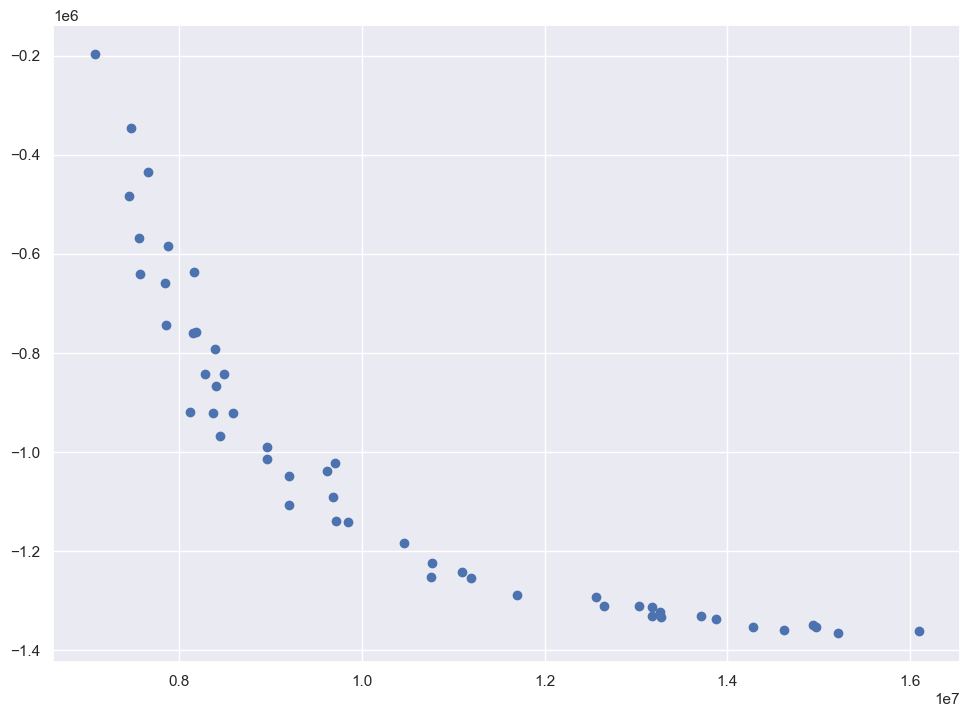

In [501]:
plt.scatter([sol.tour_cost for sol in evaled_pop], [-1 * sol.packing_plan_cost for sol in evaled_pop])

In [502]:
import pandas as pd
df = pd.DataFrame()
df['tour_cost'] = [sol.tour_cost for sol in evaled_pop]
df['packing_plan_cost'] = [-1 * sol.packing_plan_cost for sol in evaled_pop]
df["rank"] = [sol.rank for sol in evaled_pop]
print(df)

       tour_cost  packing_plan_cost  rank
0   7.837195e+06          -659176.0     1
1   1.521684e+07         -1365333.0     1
2   1.303472e+07         -1311929.0     2
3   7.070826e+06          -196426.0     1
4   1.327269e+07         -1332677.0     1
5   7.556785e+06          -568219.0     1
6   1.169331e+07         -1290194.0     1
7   8.402553e+06          -868066.0     2
8   8.484207e+06          -843034.0     3
9   9.679764e+06         -1091936.0     2
10  7.877759e+06          -584485.0     2
11  1.494055e+07         -1350772.0     2
12  9.201226e+06         -1106499.0     1
13  8.177144e+06          -757980.0     3
14  1.609693e+07         -1362858.0     2
15  8.389642e+06          -792134.0     3
16  1.119696e+07         -1255145.0     1
17  8.150662e+06          -760013.0     2
18  1.108994e+07         -1242874.0     2
19  8.588297e+06          -921282.0     2
20  8.957163e+06         -1015061.0     1
21  9.708968e+06         -1023015.0     4
22  8.114929e+06          -918897.

<Axes: xlabel='tour_cost', ylabel='packing_plan_cost'>

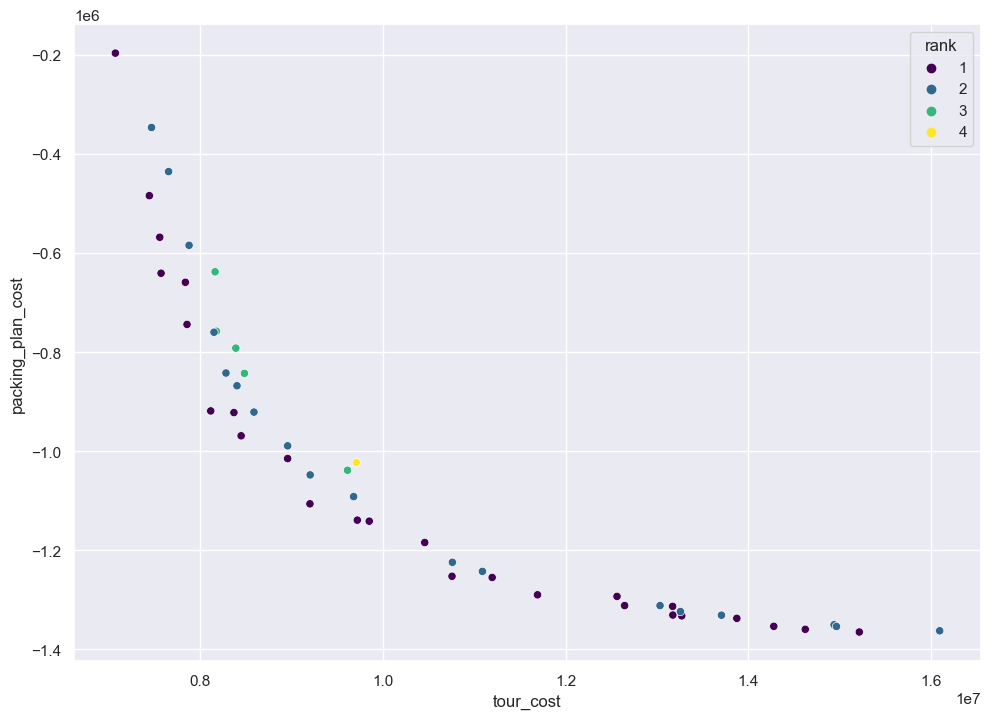

In [503]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x='tour_cost', y='packing_plan_cost', data=df, hue='rank',palette = "viridis")

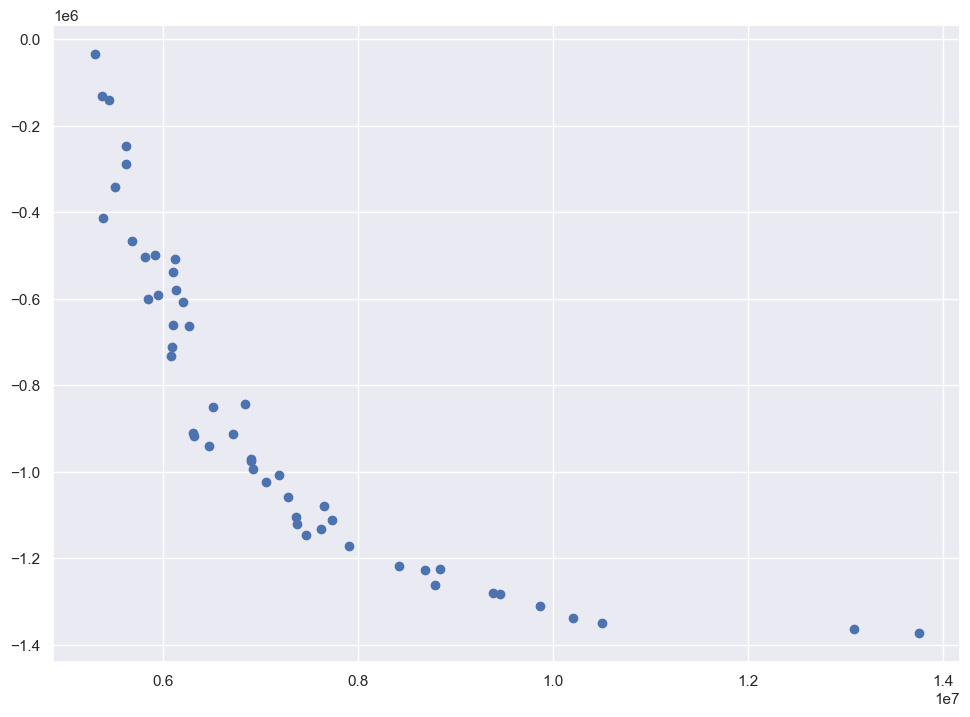

In [451]:
plt.scatter([sol.tour_cost for sol in evaled_pop], [-1 * sol.packing_plan_cost for sol in evaled_pop])

In [527]:
def tournament_selection(population): # Swaroop
    
    """
      .

    Parameters:
    - population (list): list of candidate solutions represented as structures
      from the ypstruct library with the following attributes:
        - tour (numpy.ndarray): An array representing the sequence of cities visited.
        - knapsack (numpy.ndarray): A binary array indicating items picked (1) or not (0).
        - knapsack_cost (float): The total value of the knapsack
        - tour_cost (float): The total length of the tour
        - rank (integer): The NSGA-II rank of the candidate solution
        - crowding_distance (float): the NSGA-II crowding distance of the candidate solution
    
    Randomly select 2 candidate solutions from the population (without replacement) compare first their rank (return) the one with the lowest 
    rank. If they have the same rank, return solution with greater crowding distance.

    Return: 
    ypstruct.Struct: candidate solution represented in the same way as the candidate solutions in the population
    """

  # Randomly select 2 candidate solutions from the population (without replacement)
    candidates = random.sample(population, k=2)
    # Compare their ranks
    if candidates[0].rank < candidates[1].rank:
        return candidates[0]  # Return the solution with lower rank
    elif candidates[0].rank > candidates[1].rank:
        return candidates[1]  # Return the solution with lower rank
    else:  # If ranks are equal, choose the one with greater crowding distance
        if candidates[0].crowding_distance > candidates[1].crowding_distance:
            return candidates[0]  # Return the solution with greater crowding distance
        else:
            return candidates[1]  # Return the solution with greater crowding distance

In [528]:
for candidate_solution in ex_init_pop:
    candidate_solution.rank = random.sample(list(range(1, 4)), k = 1)[0]
    candidate_solution.crowding_distance = np.random.random(1)[0]

In [533]:
a, b = [structure(), structure()]
a.rank, b.rank = [1, 2]
a.crowding_distance, b.crowding_distance = [1, 2]

In [534]:
tournament_selection([a, b])

struct({'rank': 1, 'crowding_distance': 1})

In [ ]:
def find_min_indices_in_row(matrix, row_index):
    row = matrix[row_index, :]
    min_value = np.min(row)
    min_indices = np.where(row == min_value)

    if len(min_indices[0]) == 1:
        # If there's a single minimum value, return only its index in the specified row
        return [min_indices[0][0]]
    else:
        # If there are duplicates, return all occurrences within the specified row
        return [col_index for col_index in min_indices[0]]


In [ ]:
def nearest_neighbour(distance_matrix):
    dist_matrix = distance_matrix.copy()
    num_cities = dist_matrix.shape[0]
    start_city = random.sample(list(range(num_cities)), k = 1)
    dist_matrix[:, start_city[0]] = np.inf

    for _ in range(1, num_cities):
        current_city = start_city[-1]
        next_city = random.sample(find_min_indices_in_row(dist_matrix, current_city), k = 1)[0]
        start_city.append(next_city)
        dist_matrix[:, next_city] = np.inf
    
    return start_city

        

In [ ]:
def tour_length(tour, distance_matrix: list[list]) -> float:
    
    # cost of going from last city in the chromosme back to the starting chromosome
    return_to_start_length = distance_matrix[len(distance_matrix)-1][tour[0]]
    # calculate the cost for the rest of the tour
    travel_length = 0
    for i in range(0, len(distance_matrix)-1, 1):
        travel_length += distance_matrix[tour[i]][tour[i+1]]

    return travel_length + return_to_start_length


In [ ]:
def nearest_neighbour_2opt(distance_matrix):
    tour = nearest_neighbour(distance_matrix=distance_matrix)
    number_of_cities = distance_matrix.shape[0]
    max_2opt_moves = (number_of_cities) * (number_of_cities - 1) / 2
    made_moves = []
    length = tour_length(tour, distance_matrix)
    better = False
    i = 0 

    while not better and i < max_2opt_moves:
        i += 1
        idx = range(len(tour))
        made_move = False
        i1, i2 = (None, None)
        while not made_move:
            i1_test, i2_test = random.sample(idx, 2)
            if (i1_test, i2_test) in made_moves or (i2_test, i1_test) in made_moves:
                continue
            else:
                i1, i2 = i1_test, i2_test
                made_move = True
        made_moves.append((i1, i2))
        made_moves.append((i2, i1))
        new_tour = tour.copy()
        new_tour[i1], new_tour[i2] = new_tour[i2], new_tour[i1]
        if tour_length(new_tour, distance_matrix) < length:
            better = True
            tour = new_tour
    return tour


   